- ネガティブサンプリングを試した
- コンテキストの長さを長くした

In [79]:
import sys

sys.path.append("..")

In [80]:
import random

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib

from src.util import *
from src.model import *

tqdm.pandas()

In [81]:
last_review_date = pd.to_datetime("2015/01/01")
train_split_date = pd.to_datetime("2017/01/01")
test_split_date = pd.to_datetime("2018/01/01")

seed = 0
random.seed(seed)
np.random.seed(seed)

In [82]:
interaction_df, user_le, item_le = load_interaction_df(
    last_review_date=last_review_date,
    train_split_date=train_split_date,
)
items = item_le.transform(item_le.classes_)

(
    train_dataset,
    test_dataset,
    train_user_feature_table,
    test_user_feature_table,
    negative_sampler,
) = create_dataset(
    interaction_df=interaction_df,
    train_split_date=train_split_date,
    test_split_date=test_split_date,
    item_size=len(items),
)

100%|██████████| 25093/25093 [00:00<00:00, 3538688.40it/s]


In [83]:
class Model2(torch.nn.Module):
    def __init__(
        self,
        item_size: int,
        user_feature_dim: int,
        num_layers: int = 4,
        d_model: int = 64,
        dim_feedforward: int = 128,
        nhead: int = 4,
    ) -> None:
        super().__init__()
        self.user_embedding = torch.nn.Linear(user_feature_dim, d_model)
        self.item_embedding = torch.nn.Embedding(item_size, d_model)

        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.transformer_layer = torch.nn.TransformerEncoder(
            encoder_layer=torch.nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        self.clv_layer = TwoFeedForwardLayer(d_model, d_model // 2, 1)
        self.target_layer = TwoFeedForwardLayer(d_model, d_model * 2, d_model)

    def forward(
        self,
        user_features: torch.Tensor,
        item_indices: torch.Tensor,
        target_indices: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        e_u = self.user_embedding.forward(user_features)
        e_v = self.item_embedding.forward(item_indices)
        e_v = self.positional_encoding.forward(e_v)
        H = torch.cat((e_u.unsqueeze(1), e_v), dim=1)
        H = self.transformer_layer.forward(H)

        y_clv = torch.sigmoid(self.clv_layer.forward(H[:, 0]))
        H_v = self.target_layer.forward(H[:, -1])

        e_target = self.item_embedding.forward(target_indices)
        v_target = torch.matmul(H_v.unsqueeze(1), e_target.mT)
        y_target = torch.sigmoid(v_target)

        return y_clv.squeeze(), y_target.squeeze()

In [84]:
def run_one_epoch(
    model: Model2,
    dataloader: torch.utils.data.DataLoader,
    user_feature_table: np.ndarray,
    negative_sampler: NegativeSampler,
    optimizer: torch.optim.Optimizer,
    args: Args,
    items: list[int],
    is_eval: bool = False,
) -> dict:
    result: dict[str, dict] = {
        "target": {"loss": 0.0, "y_pred": [], "y_true": []},
        "clv": {"loss": 0.0, "y_pred": [], "y_true": []},
    }

    if is_eval:
        model.eval()
    else:
        model.train()

    for batch in tqdm(dataloader):
        user_ids = []
        item_indices = []
        target_indices = []
        target_labels = []
        clv_labels = []

        for user_id, user_context_items, target_items, clv in batch:
            for _ in range(args.sample_size):
                context_item_indices = []
                for _ in range(args.context_item_size):
                    context_item_indices.append(random.randrange(len(user_context_items)))
                context_item_indices.sort()
                context_items = [user_context_items[i] for i in context_item_indices]

                user_ids.append(user_id)
                item_indices.append(context_items)
                clv_labels.append(clv)
                target_indices.append([])
                target_labels.append([])

                # 正例
                for _ in range(min(5, len(target_items))):
                    target_indices[-1].append(
                        target_items[random.randrange(0, len(target_items))]
                    )
                    target_labels[-1].append(1)

                # 負例
                negative_sample_size = args.negative_sample_size - len(target_indices[-1])
                target_indices[-1].extend(negative_sampler.sample(negative_sample_size).tolist())
                target_labels[-1].extend([0] * negative_sample_size)

        user_features = torch.FloatTensor(user_feature_table[user_ids]).to(args.device)
        item_indices = torch.LongTensor(item_indices).to(args.device)
        target_indices = torch.LongTensor(target_indices).to(args.device)
        target_labels = torch.FloatTensor(target_labels).to(args.device).flatten()
        clv_labels = torch.FloatTensor(clv_labels).to(args.device).flatten()

        y_clv, y_target = model.forward(user_features, item_indices, target_indices)
        y_clv = y_clv.flatten()
        y_target = y_target.flatten()

        target_loss = torch.nn.functional.binary_cross_entropy(y_target, target_labels)
        clv_loss = torch.nn.functional.binary_cross_entropy(y_clv, clv_labels)
        loss = target_loss * args.alpha + clv_loss * (1 - args.alpha)

        if not is_eval:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        result["target"]["loss"] += target_loss.item()
        result["target"]["y_pred"].extend(y_target.tolist())
        result["target"]["y_true"].extend(target_labels.tolist())
        result["clv"]["loss"] += clv_loss.item()
        result["clv"]["y_pred"].extend(y_clv.tolist())
        result["clv"]["y_true"].extend(clv_labels.tolist())

    for term_name in result.keys():
        result[term_name]["loss"] /= len(dataloader)

    return result


def train(
    model: Model2,
    train_dataset: Dataset,
    test_dataset: Dataset,
    train_user_feature_table: np.ndarray,
    test_user_feature_table: np.ndarray,
    negative_sampler: NegativeSampler,
    args: Args,
    items: list[int],
) -> tuple[list[dict], list[dict]]:
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=lambda x: x,  # 各データは形式が異なるため、バッチ化せずにそのまま返す
    )
    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda x: x,  # 各データは形式が異なるため、バッチ化せずにそのまま返す
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    train_results = []
    test_results = []

    for epoch in range(args.epochs):
        print(f"[epoch: {epoch + 1}/{args.epochs}]")
        train_result = run_one_epoch(
            model=model,
            dataloader=train_dataloader,
            user_feature_table=train_user_feature_table,
            negative_sampler=negative_sampler,
            optimizer=optimizer,
            args=args,
            items=items,
        )
        print(
            f"[train][loss] target_loss: {train_result['target']['loss']:.6f}, clv_loss: {train_result['clv']['loss']:.6f}"
        )
        train_results.append(train_result)

        test_result = run_one_epoch(
            model=model,
            dataloader=test_dataloader,
            user_feature_table=test_user_feature_table,
            negative_sampler=negative_sampler,
            optimizer=optimizer,
            args=args,
            items=items,
            is_eval=True,
        )
        print(
            f"[test][loss] target_loss: {test_result['target']['loss']:.6f}, clv_loss: {test_result['clv']['loss']:.6f}"
        )
        test_results.append(test_result)

        torch.save(model, args.model_path)
        print(f"saved model to: {args.model_path}")

    return train_results, test_results

In [86]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

target_loss_weight = 1
clv_loss_weight = 1
alpha = target_loss_weight / (target_loss_weight + clv_loss_weight)

args = Args(
    d_model=32,
    dim_feedforward=64,
    batch_size=16,
    nhead=4,
    num_layers=4,
    epochs=10,
    lr=1e-3,
    sample_size=5,
    negative_sample_size=100,
    alpha=alpha,
    context_item_size=100,
    device=device,
    model_path="model2_e10_test5.model",
)

try:
    model = torch.load(args.model_path)
    print(f"loaded model from: {args.model_path}")
except FileNotFoundError:
    model = Model2(
        item_size=len(items),
        user_feature_dim=train_user_feature_table.shape[1],
        d_model=args.d_model,
        dim_feedforward=args.dim_feedforward,
        nhead=args.nhead,
        num_layers=args.num_layers,
    )
model.to(args.device)
model.train()

print(f"args: {args}")
train_results, test_results = train(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    train_user_feature_table=train_user_feature_table,
    test_user_feature_table=test_user_feature_table,
    negative_sampler=negative_sampler,
    args=args,
    items=items,
)

args: Args(d_model=32, dim_feedforward=64, batch_size=16, nhead=4, num_layers=4, epochs=10, lr=0.001, sample_size=5, negative_sample_size=100, alpha=0.5, context_item_size=200, device='mps', model_path='model2_e10_test4.model')
[epoch: 1/10]


100%|██████████| 1569/1569 [04:24<00:00,  5.93it/s]


[train][loss] target_loss: 0.216165, clv_loss: 0.318428


100%|██████████| 1569/1569 [02:39<00:00,  9.83it/s]


[test][loss] target_loss: 0.069741, clv_loss: 0.306934
saved model to: model2_e10_test4.model
[epoch: 2/10]


100%|██████████| 1569/1569 [04:21<00:00,  6.00it/s]


[train][loss] target_loss: 0.057499, clv_loss: 0.304118


100%|██████████| 1569/1569 [02:42<00:00,  9.63it/s]


[test][loss] target_loss: 0.047705, clv_loss: 0.297283
saved model to: model2_e10_test4.model
[epoch: 3/10]


100%|██████████| 1569/1569 [04:12<00:00,  6.22it/s]


[train][loss] target_loss: 0.044206, clv_loss: 0.298021


100%|██████████| 1569/1569 [01:55<00:00, 13.61it/s]


[test][loss] target_loss: 0.042977, clv_loss: 0.292110
saved model to: model2_e10_test4.model
[epoch: 4/10]


100%|██████████| 1569/1569 [04:01<00:00,  6.50it/s]


[train][loss] target_loss: 0.040982, clv_loss: 0.291357


100%|██████████| 1569/1569 [01:54<00:00, 13.72it/s]


[test][loss] target_loss: 0.042516, clv_loss: 0.295728
saved model to: model2_e10_test4.model
[epoch: 5/10]


100%|██████████| 1569/1569 [04:00<00:00,  6.52it/s]


[train][loss] target_loss: 0.039989, clv_loss: 0.285073


100%|██████████| 1569/1569 [01:57<00:00, 13.40it/s]


[test][loss] target_loss: 0.042558, clv_loss: 0.291691
saved model to: model2_e10_test4.model
[epoch: 6/10]


100%|██████████| 1569/1569 [04:06<00:00,  6.36it/s]


[train][loss] target_loss: 0.039522, clv_loss: 0.277030


100%|██████████| 1569/1569 [01:57<00:00, 13.35it/s]


[test][loss] target_loss: 0.043602, clv_loss: 0.300512
saved model to: model2_e10_test4.model
[epoch: 7/10]


  8%|▊         | 118/1569 [00:18<03:46,  6.40it/s]


KeyboardInterrupt: 

([-10.740679240037855, -0.5701078547960363, -0.12372521895414068, 0.009860592706620985, 0.05414875190184032, 0.07071665725444565, 0.07647554407279122, 0.0798279163447797, 0.08079605628878339, 0.08314295259344118], [-1.1246376401633524, -0.24376571071021225, -0.03626216541798022, 0.02896716296986801, 0.04516376982111325, 0.04850990126766119, 0.04788690843228083, 0.045989034186743716, 0.04664736275056702, 0.04664562893886903])
([0.39281278576812917, 0.4237860820795565, 0.42946587046487184, 0.43637915392829507, 0.44326595854511375, 0.45268196316883136, 0.4586745310309239, 0.4645233110437964, 0.4715381040379458, 0.47644759549907056], [0.42508010601371604, 0.3964926359308998, 0.429565285325052, 0.4140238434191913, 0.4394320517349565, 0.4192385885208929, 0.434855481235354, 0.4284860763700359, 0.4297667722068709, 0.4188925534432649])


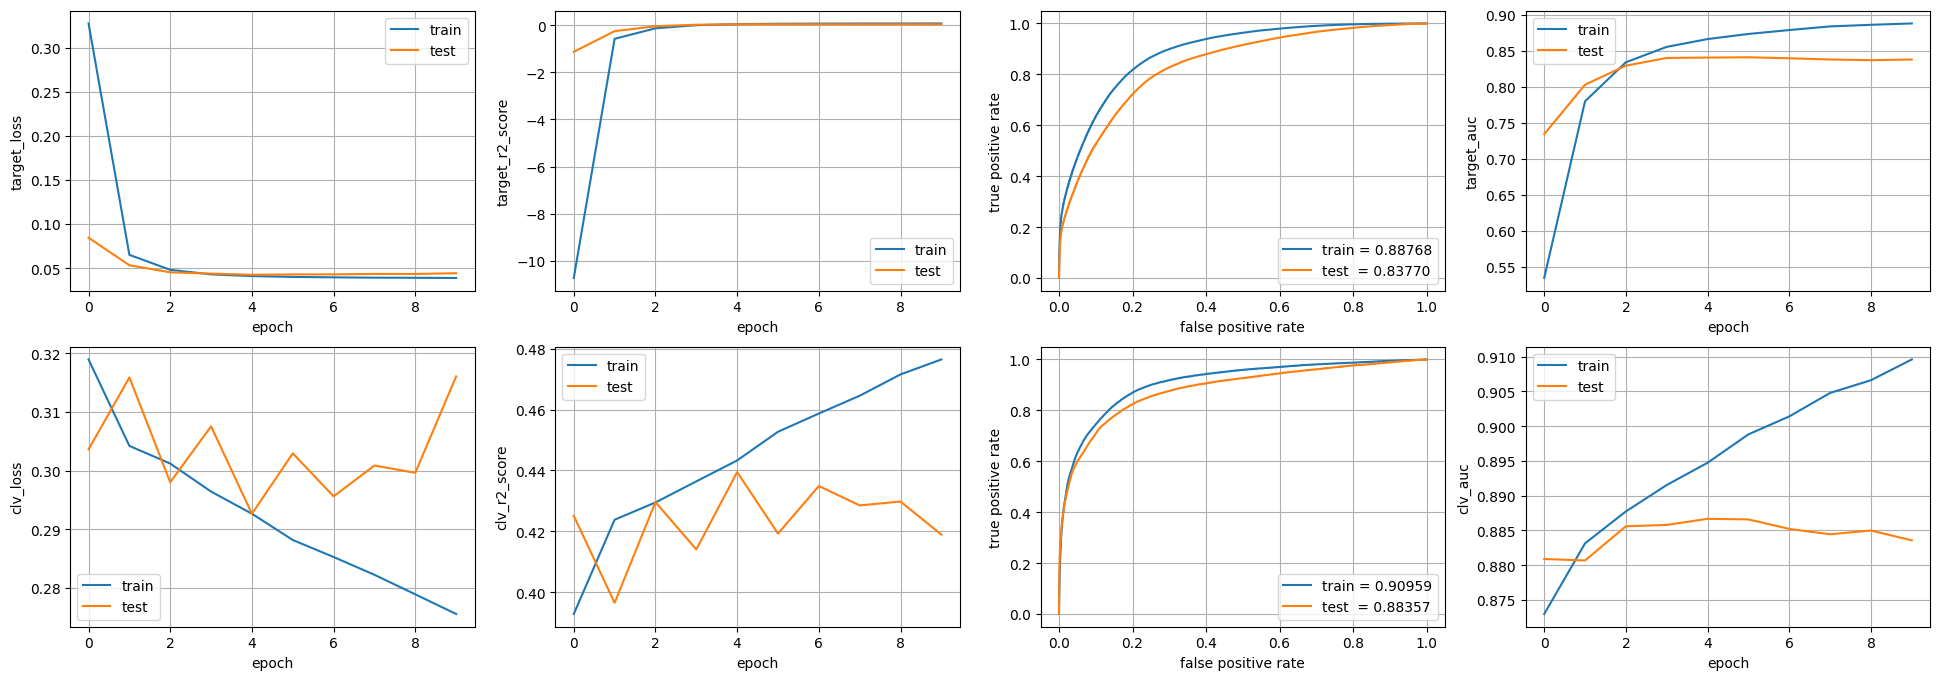

In [88]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 8))
loss_names = ["target", "clv"]

for i, loss_name in enumerate(loss_names):
    plot_loss(train_results, test_results, loss_name, axes[i, 0])
    print(plot_r2_score(train_results, test_results, loss_name, axes[i, 1]))
    plot_roc_auc(train_results[-1], test_results[-1], loss_name, axes[i, 2])
    plot_auc(train_results, test_results, loss_name, axes[i, 3])

plt.show()

In [89]:
# for user_id, user_context_items, target_items, clv in tqdm(train_dataset):
#     if len(target_items) == 0:
#         continue
#     user_ids = []
#     item_indices = []
#     for _ in range(2):
#         context_item_indices = []
#         for _ in range(args.context_item_size):
#             context_item_indices.append(random.randrange(len(user_context_items)))
#         context_item_indices.sort()
#         context_items = [user_context_items[i] for i in context_item_indices]

#         user_ids.append(user_id)
#         item_indices.append(context_items)

#     user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
#     item_indices = torch.LongTensor(item_indices).to(args.device)
#     target_indices = torch.LongTensor(items).to(args.device)

#     with torch.no_grad():
#         e_u = model.user_embedding.forward(user_features)
#         e_v = model.item_embedding.forward(item_indices)
#         e_v = model.positional_encoding.forward(e_v)
#         H = torch.cat((e_u.unsqueeze(1), e_v), dim=1)
#         H = model.transformer_layer.forward(H)

#         y_clv = torch.sigmoid(model.clv_layer.forward(H[:, 0]))
#         H_v = model.target_layer.forward(H[:, -1])

#         e_target = model.item_embedding.forward(target_indices)
#         v_target = torch.matmul(H_v.unsqueeze(1), e_target.mT)
#         y_target = torch.sigmoid(v_target)
#         # print(H.shape, H)
#         x = H[:, -1]
#         # print("1:", x)
#         x = model.target_layer.fc1.forward(x)
#         # print("2:", x)
#         x = torch.nn.functional.leaky_relu(x)
#         # print("3:", x)
#         x = model.target_layer.fc2.forward(x)
#         # print("4:", x)
#         # print("b:", model.target_layer.fc2.bias)
#         # print(H_v)
#         # print(e_target)
#         # print(v_target)
#         print(y_target[0][0][:7])

In [90]:
model.eval()

before_rerank_size = 50
filter_sample_size = 10
rerank_sample_size = 10
top_k = 10

total_count = 0
before_hit_count = 0
after_hit_count = 0

recommendations = {}

for user_id, user_context_items, target_items, clv in tqdm(train_dataset):
    if len(target_items) == 0:
        continue
    total_count += 1

    recommendations[user_id] = {}

    user_ids = []
    item_indices = []
    context_items = user_context_items[-args.context_item_size:]
    user_ids.append(user_id)
    item_indices.append(context_items)

    user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
    item_indices = torch.LongTensor(item_indices).to(args.device)
    target_indices = torch.LongTensor(items).to(args.device)

    with torch.no_grad():
        _, y_target = model.forward(
            user_features, item_indices, target_indices=target_indices
        )

    b = y_target.cpu().detach().numpy()

    before_rerank_rec = items[np.argsort(b)][::-1][
        :before_rerank_size
    ]  # 降順でソートし、上位`before_rerank_size`件を取得する

    hit = len(set(before_rerank_rec[:top_k]) & set(target_items))
    # print("before rerank:", hit, "/", len(target_items))
    if hit > 0:
        before_hit_count += 1

    clv_mean = []
    user_ids = []
    item_indices = []
    for target_item in before_rerank_rec:
        for _ in range(rerank_sample_size):
            context_item_indices = []
            for _ in range(args.context_item_size):
                context_item_indices.append(random.randrange(len(user_context_items)))
            context_item_indices.sort()
            context_items = [user_context_items[i] for i in context_item_indices]

            v = list(context_items)
            v.append(target_item)
            user_ids.append(user_id)
            item_indices.append(v)

    user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
    item_indices = torch.LongTensor(item_indices).to(args.device)
    target_indices = torch.LongTensor([0]).to(args.device)  # CLVのみを計算するので、ダミーを入れておく

    with torch.no_grad():
        y_clv, _ = model.forward(user_features, item_indices, target_indices)

    y_clv = y_clv.cpu().detach().numpy()
    clv_mean = np.add.reduceat(y_clv, np.arange(0, y_clv.shape[0], rerank_sample_size))

    after_rerank_rec = before_rerank_rec[np.argsort(clv_mean)][::-1]

    hit = len(set(after_rerank_rec[:top_k]) & set(target_items))

    # print("after rerank:", hit, "/", len(target_items))
    if hit > 0:
        after_hit_count += 1

    recommendations[user_id]["target_items"] = item_le.inverse_transform(
        target_items
    ).tolist()
    recommendations[user_id]["before_rerank_rec"] = item_le.inverse_transform(
        before_rerank_rec
    ).tolist()
    recommendations[user_id]["before_rerank_rec_value"] = b[before_rerank_rec].tolist()
    recommendations[user_id]["after_rerank_rec"] = item_le.inverse_transform(
        after_rerank_rec
    ).tolist()
    recommendations[user_id]["after_rerank_rec_value"] = b[after_rerank_rec].tolist()


print(f"before hit-ratio:  {before_hit_count / total_count:.5f}")
print(f"after hit-ratio:   {after_hit_count / total_count:.5f}")

100%|██████████| 25093/25093 [19:32<00:00, 21.40it/s]

before hit-ratio:  0.56060
after hit-ratio:   0.41733


In [91]:
rec_df = pd.DataFrame.from_dict(recommendations, orient="index")
rec_df.index = rec_df.index.rename("user_id")
rec_df.to_csv("../out/rec13.csv")

In [92]:
for i in range(10):
    print(sorted(rec_df.before_rerank_rec_value.iloc[i], reverse=True))

[0.5052818655967712, 0.46946585178375244, 0.3492225706577301, 0.33562323451042175, 0.3316341042518616, 0.32511579990386963, 0.31598803400993347, 0.30270302295684814, 0.29194918274879456, 0.2856682240962982, 0.28395166993141174, 0.2806723713874817, 0.2726602256298065, 0.27241212129592896, 0.2714153230190277, 0.2678902745246887, 0.2647430896759033, 0.2597771883010864, 0.25681042671203613, 0.2526830732822418, 0.25065624713897705, 0.24657517671585083, 0.2424011528491974, 0.24217794835567474, 0.23856577277183533, 0.23587560653686523, 0.2354007363319397, 0.23523251712322235, 0.23473596572875977, 0.23316600918769836, 0.23167267441749573, 0.23150157928466797, 0.23112204670906067, 0.22942887246608734, 0.22938376665115356, 0.2261316031217575, 0.2237345427274704, 0.22240996360778809, 0.2191675901412964, 0.21673454344272614, 0.21632657945156097, 0.21411927044391632, 0.2135523110628128, 0.21354761719703674, 0.21297690272331238, 0.21110868453979492, 0.21098507940769196, 0.2089073359966278, 0.2070817

In [93]:
for i in range(10):
    print(rec_df.before_rerank_rec.iloc[i])

['202511', '200416', '164179', '198339', '166461', '164909', '169304', '166643', '185563', '168612', '168500', '163134', '174055', '122918', '147562', '193095', '195429', '205102', '160824', '135143', '147055', '160990', '161185', '167370', '161582', '169984', '170697', '146678', '169744', '150254', '166946', '135436', '189355', '166528', '162738', '175213', '178081', '166635', '169802', '122916', '167842', '168366', '163645', '162672', '160980', '165347', '171749', '171495', '169982', '168250']
['202511', '200416', '164909', '164179', '169744', '174055', '195429', '168252', '163134', '166528', '162606', '166643', '163645', '172459', '185563', '166461', '165551', '178081', '147562', '168500', '169984', '168250', '162414', '161185', '122918', '166635', '168366', '143355', '201322', '122922', '165549', '176371', '171763', '160718', '122926', '169906', '160980', '176101', '150254', '170705', '162350', '166486', '146678', '169304', '166534', '176631', '168326', '170697', '205102', '162600'

In [94]:
st = set()
for v in rec_df.before_rerank_rec:
    for e in v:
        st.add(e)
print(f"{len(st)}/{len(rec_df)}")

304/4893


In [95]:
st = set()
for v in rec_df.target_items:
    for e in v:
        st.add(e)
print(f"{len(st)}/{len(rec_df)}")

25778/4893


In [ ]:
# 393/4893